# Initial study

This notebook identifies PPMI subjects to reproduce the following paper:


<div class="alert alert-block alert-success">
Shu, Zhen‐Yu, et al. <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.28522?casa_token=Ab53WvMlODcAAAAA%3AXcgDLmq8egqW7uwd2g3jY9jIljhLu3VhIbvMWgbcfoWOxjO_9H7Arf91t2FBZDZ8E94Je4Wmrn0ZmkeZ">Predicting the progression of Parkinson's disease using conventional MRI and machine learning: An application of radiomic biomarkers in whole‐brain white matter.</a> Magnetic Resonance in Medicine 85.3 (2021): 1611-1624.</div>

This study used the following population from PPMI:
<img src="../data/table.png"/>

Note: this notebook can be shared publicly. It is implemented to not leak any PPMI patient information or id.

# Data loading and preparation

## Metadata download

In [374]:
import os
import ppmi_downloader

data_dir = 'data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
required_files = ['Age_at_visit.csv', 'Demographics.csv',
                  'Magnetic_Resonance_Imaging__MRI_.csv', 'MDS_UPDRS_Part_III.csv']
missing_files = [x for x in required_files if not os.path.exists(os.path.join(data_dir, x))]

if len(missing_files) > 0:
    ppmi = ppmi_downloader.PPMIDownloader('mohanadarafework@gmail.com', 'MohanadKhadija91!')
    ppmi.download_metadata(missing_files, destination_dir=data_dir, headless=False, timeout=600)

## Hoehn & Yahr score

In [375]:
import pandas as pd
import numpy as np

df_hy = pd.read_csv(os.path.join(data_dir, 'MDS_UPDRS_Part_III.csv'))

# Keep only H&Y values for PDSTATE=OFF or (PDSTATE=NaN and PDTRTMNT=0, i.e., patient is not medicated)
df_hy = df_hy[(df_hy['PDSTATE'] == 'OFF') | ((df_hy['PDSTATE'].isnull()) & ((df_hy['PDTRTMNT'] == 0)) | (df_hy['PDTRTMNT'].isnull())) ]

# Drop useless columns
keep_cols = ['EVENT_ID', 'PATNO', 'NHY', 'PDSTATE', 'PDTRTMNT']
df_hy = df_hy.drop([x for x in df_hy.columns if x not in keep_cols], axis=1)

# Show H&Y stats
df_hy

c:\users\mohanadarafe\appdata\local\programs\python\python37-32\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (10,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,PATNO,EVENT_ID,PDSTATE,NHY,PDTRTMNT
0,3000,BL,NaN,0,NaN
1,3000,V04,NaN,0,NaN
2,3000,V06,NaN,0,NaN
3,3000,V08,NaN,0,NaN
4,3000,V10,NaN,0,NaN
...,...,...,...,...,...
18270,148093,BL,NaN,2,0.0
18271,150818,BL,NaN,0,0.0
18272,151111,BL,NaN,2,0.0
18273,151111,BL,NaN,NaN,NaN


### Building dataframe with 3D T1 scans

In [376]:
# Read CSV
patients_df = pd.read_csv("./data/MRI_info.csv")

# Keep rows with visits we need
patients_df = patients_df[patients_df['Visit'].isin(['Baseline', 'Month 12', 'Month 24', 'Month 36', 'Month 48']) == True]
patients_df["Visit"] = patients_df["Visit"].replace(['Baseline', 'Month 12', 'Month 24', 'Month 36', 'Month 48'], ['BL', 'V04', 'V06', 'V08', 'V10'])
patients_df["Subject ID"] = patients_df["Subject ID"].astype(np.int64)
patients_df["Description"] = patients_df["Description"].astype(str)
patients_df = patients_df.rename(columns={"Subject ID": "PATNO", "Visit": "EVENT_ID"})

# Merge UPDRS and MRI dataframes
df_hy=pd.merge(df_hy, patients_df, how='left',on=['PATNO', 'EVENT_ID'])
df_hy

,PATNO,EVENT_ID,PDSTATE,NHY,PDTRTMNT,Sex,Age,Description,Visit code
0,3000,BL,NaN,0,NaN,F,69.1,sag 3D FSPGR BRAVO straight,BL
1,3000,V04,NaN,0,NaN,NaN,NaN,NaN,NaN
2,3000,V06,NaN,0,NaN,NaN,NaN,NaN,NaN
3,3000,V08,NaN,0,NaN,NaN,NaN,NaN,NaN
4,3000,V10,NaN,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
13239,148093,BL,NaN,2,0.0,NaN,NaN,NaN,NaN
13240,150818,BL,NaN,0,0.0,NaN,NaN,NaN,NaN
13241,151111,BL,NaN,2,0.0,NaN,NaN,NaN,NaN
13242,151111,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [377]:
patients_df

,PATNO,Sex,EVENT_ID,Age,Description,Visit code
0,100001,M,BL,67.4,SAG 3D MPRAGE,BL
1,100017,F,BL,58.8,SAG 3D MPRAGE,BL
2,100017,F,V04,59.7,SAG 3D MPRAGE,V04
3,100738,F,BL,71.3,SAG FSPGR 3D VOLUMETRIC T1,BL
4,100878,M,BL,65.9,3D T1-weighted,BL
...,...,...,...,...,...,...
2088,85242,M,V06,66.1,MPRAGE_GRAPPA,V06
2089,85242,M,V06,66.1,MPRAGE_GRAPPA_ADNI,V06
2090,90456,M,BL,82.5,sag mprage,BL
2091,91097,M,BL,67.3,FSPGR 3D SAG,BL


## Demographics

Needed for sex.

In [352]:
demo = pd.read_csv(os.path.join(data_dir, 'Demographics.csv'))

# Drop useless columns
keep = ['PATNO', 'SEX']
demo = demo.drop([x for x in demo.columns if x not in keep], axis=1)

#
demo['SEX'] = demo['SEX'].astype(int)

# Show sex stats (0: Female, 1: Male)
demo.groupby('SEX').count()

,PATNO
SEX,
0,944
1,1276


## Age at visit

<AxesSubplot:>

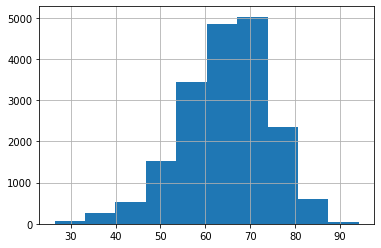

In [353]:
df_age = pd.read_csv(os.path.join(data_dir, 'Age_at_visit.csv'))

# Show histogram
df_age['AGE_AT_VISIT'].hist()

## MRI availability

In [354]:
mri_df = pd.read_csv(os.path.join(data_dir, 'Magnetic_Resonance_Imaging__MRI_.csv'))
keep_cols = ['EVENT_ID', 'PATNO', 'MRICMPLT']
mri_df = mri_df.drop([x for x in mri_df.columns if x not in keep_cols], axis=1)
mri_df.groupby('MRICMPLT').count()

,PATNO,EVENT_ID
MRICMPLT,,
0.0,500,500
1.0,2380,2380


## Merge H&Y, age and MRI information

In [355]:
keys = ['PATNO', 'EVENT_ID']
df = df_hy.merge(df_age, on=keys).merge(mri_df, on=keys)
df

,PATNO,EVENT_ID,PDSTATE,NHY,PDTRTMNT,Sex,Age,Description,Visit code,AGE_AT_VISIT,MRICMPLT
0,3000,BL,NaN,0,NaN,F,69.1,sag 3D FSPGR BRAVO straight,BL,69.1,1.0
1,3000,V12,NaN,0,NaN,NaN,NaN,NaN,NaN,74.3,0.0
2,3001,BL,NaN,1,0.0,M,65.1,sag 3D FSPGR BRAVO straight,BL,65.1,1.0
3,3002,BL,NaN,2,0.0,F,67.6,sag 3D FSPGR BRAVO straight,BL,67.6,1.0
4,3003,BL,NaN,2,0.0,F,56.7,sag 3D FSPGR BRAVO straight,BL,56.7,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2874,148093,BL,NaN,2,0.0,NaN,NaN,NaN,NaN,64.5,1.0
2875,150818,BL,NaN,0,0.0,NaN,NaN,NaN,NaN,79.3,1.0
2876,151111,BL,NaN,2,0.0,NaN,NaN,NaN,NaN,37.7,1.0
2877,151111,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.7,1.0


## Format data by visit pairs

In [356]:
# We need a 3-year gap between visits so the only possible pairs are the following ones:
visits = {'BL': 'V08', 
          'V04': 'V10',
          'V06': 'V12',
          'V08': 'V13',
          'V10': 'V14'}
def next_visit(x):
    return visits[x]

In [357]:
# Keep only visit pairs for which the first visit is in the list of possible pairs
# and has MRI available
visits_df = df[(df['MRICMPLT']==1.0) & (df['EVENT_ID'].isin(visits))]

# Set id of second visit in pair
visits_df['next_visit'] = visits_df['EVENT_ID'].apply(next_visit)

# Retrieve H&Y score of next visit
visits_df = visits_df.merge(df_hy, how='left', left_on=['PATNO', 'next_visit'], right_on=['PATNO', 'EVENT_ID'])

# Add patient sex to visit pairs
visits_df = visits_df.merge(demo, on=['PATNO'])

# Define visit as stable if NHY (first visit)
visits_df['stable'] = (visits_df['NHY_x'] == visits_df['NHY_y'])

c:\users\mohanadarafe\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [335]:
visits_df.groupby(['stable', 'NHY_x']).count()

PATNO  EVENT_ID_x  PDSTATE_x  PDTRTMNT_x  Sex_x  Age_x  \
stable NHY_x                                                           
False  0        517         517          2         466    320    320   
       1        372         372         77         357    282    282   
       2        570         570        200         542    426    426   
       3         43          43         35          43     38     38   
       4          8           8          5           8      6      6   
       5          1           1          0           1      1      1   
       UR         1           1          1           1      1      1   
True   0        585         585          0         360    428    428   
       1         64          64         16          64     48     48   
       2        348         348        183         348    303    303   
       3          1           1          1           1      1      1   

              Description_x  Visit code_x  AGE_AT_VISIT  MRICMPLT  next_visit  \
stable NHY_x                                                                    
False  0                517           320           517       517         517   
       1                372           282           372       372         372   
       2                570           426           570       570         570   
       3                 43            38            43        43          43   
       4                  8             6             8         8           8   
       5                  1             1             1         1           1   
       UR                 1             1             1         1           1   
True   0                585           428           585       585         585   
       1                 64            48            64        64          64   
       2                348           303           348       348         348   
       3                  1             1             1         1           1   

              EVENT_ID_y  PDSTATE_y  NHY_y  PDTRTMNT_y  Sex_y  Age_y  \
stable NHY_x                                                           
False  0              39          5     39          37      0      0   
       1             153        117    153         151     19     19   
       2              65         54     65          63      7      7   
       3               7          6      7           7      0      0   
       4               2          2      2           2      0      0   
       5               0          0      0           0      0      0   
       UR              0          0      0           0      0      0   
True   0             585          1    585         362     28     28   
       1              64         46     64          64     15     15   
       2             348        316    348         348     60     60   
       3               1          1      1           1      0      0   

              Description_y  Visit code_y  SEX  
stable NHY_x                                    
False  0                 39             0  517  
       1                153            19  372  
       2                 65             7  570  
       3                  7             0   43  
       4                  2             0    8  
       5                  0             0    1  
       UR                 0             0    1  
True   0                585            28  585  
       1                 64            15   64  
       2                348            60  348  
       3                  1             0    1

# Matching

We implemented a nearest-neighbor matching loop based on the Euclidean distance. We will match stable and progressive groups for age and sex for each H&Y value.

## Normalization

We need to normalize age or else it will dominate sex in the Euclidean distance.

In [359]:
df = visits_df
to_normalize = ['AGE_AT_VISIT'] 
for var in to_normalize:
    df[f'{var}_norm'] = (df[var] - df[var].mean())/df[var].std()
df.describe()

,PATNO,PDTRTMNT_x,Age_x,AGE_AT_VISIT,MRICMPLT,PDTRTMNT_y,Age_y,SEX,AGE_AT_VISIT_norm
count,2546.000000,2191.000000,1866.000000,2546.000000,2546.0,1035.000000,129.000000,2546.000000,2.546000e+03
mean,39311.975648,0.232770,62.834084,62.992105,1.0,0.528502,63.549612,0.584839,-1.451226e-16
std,38838.670905,0.422694,9.504273,9.324848,0.0,0.499428,9.928047,0.492847,1.000000e+00
min,3000.000000,0.000000,30.600000,30.600000,1.0,0.000000,42.000000,0.000000,-3.473741e+00
25%,3587.000000,0.000000,56.500000,57.000000,1.0,0.000000,56.500000,0.000000,-6.425955e-01
50%,40806.000000,0.000000,63.800000,63.850000,1.0,1.000000,64.400000,1.000000,9.200094e-02
75%,60043.000000,0.000000,69.775000,69.700000,1.0,1.000000,71.300000,1.000000,7.193570e-01
max,151111.000000,1.000000,86.300000,86.300000,1.0,1.000000,86.300000,1.000000,2.499547e+00


In [337]:
len(pd.unique(df[(df['stable'] == True) & (df['NHY_x'] == "1")]["PATNO"]))

49

## Matching loop

Nearest neighbor matching loop applied for each H&Y value to extract stable and progressive populations with matched sex and age.

In [367]:
def nn(x, df, matched_vars):
    '''
    Find index of nearest neighbor of x in df
    '''
    
    # Select only the subjects with the same H&Y score
    df_hy_match = df[df['NHY_x'] == x['NHY_x'].values[0]]
 
    # Compute squared distance between x and all elements in df, using normalized variables
    df_hy_match['dist'] = sum((df_hy_match[f'{var}']-x[f'{var}'].values[0])**2 for var in matched_vars)
    
    # Return the element in df with the smallest distance
    df_hy_match.sort_values('dist', inplace=True)
    return df_hy_match.head(1)  ## there's probably a better way to do it but it should work

def match(n, group1_df, group2_df, matched_vars):
    '''
    Randomly pick n elements in group1_df, then find n matching elements in group2_df.
    Ensure that each group only contains 1 or less element from each patient and that 
    no patient has elements in both groups.
    '''
    
    from numpy.random import choice, seed

    # Select n random patients in group1
    group1_patnos = pd.unique(group1_df['PATNO'])
    seed(0)  # change this to bootstrap population
    group1_patnos_sample = choice(group1_patnos, n, replace=False)
    
    # Remove the selected patients from group2
    for p in group1_patnos_sample:
        group2_df = group2_df[group2_df['PATNO']!=p]
    
    group1_matched = pd.DataFrame(columns=group1_df.columns)
    group2_matched = pd.DataFrame(columns=group1_df.columns)
    
    for p in group1_patnos_sample:  # for each patient in sampled list
        # Pick a random element from this patient in group1
        s = group1_df[group1_df['PATNO'] == p].sample(1)
        # Find the best match in group2
        t = nn(s, group2_df, matched_vars)
        # Add s and t to matched groups
        group1_matched = group1_matched.append(s)
        group2_matched = group2_matched.append(t)
        # Remove t's patient from group 2 so that it doesn't get selected again
        group2_df = group2_df[group2_df['PATNO']!=t['PATNO'].values[0]]
    
    return group1_matched, group2_matched

matched_vars = ['AGE_AT_VISIT_norm', 'SEX']

        
# Apply matching to get 47 patients with H&Y=1
stable1, progr1 = match(49,
                        df[(df['stable'] == True) & (df['NHY_x'] == "1")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "1")],
                        matched_vars)

# Apply matching to get 25 patients with H&Y=2
stable2, progr2 = match(25,
                        df[(df['stable'] == True) & (df['NHY_x'] == "2")],
                        df[(df['stable'] == False) & (df['NHY_x'] == "2")],
                        matched_vars)

In [368]:
stable = stable1.append(stable2)
progr = progr1.append(progr2)

## Sanity checks

In [369]:
for (a, b) in [(stable1, progr1), (stable2, progr2)]:
    # Both groups have equal size
    assert(len(a) == len(b))
    # No patient is present more than once in each group
    for x in [a, b]:
        patnos_x = pd.unique(x['PATNO'])
        assert(len(patnos_x)==len(x)), x
    # Patients in a aren't in b
    patnos_a = pd.unique(a['PATNO'])
    patnos_b = pd.unique(b['PATNO'])
    for p in patnos_a:
        assert(p not in patnos_b), f'PATNO {p} appears in a and b'
print('All good!')

All good!


## Cohort summary

In [370]:
import os
print(f"\t\t\t\t\t| Stable set (n={len(stable)})\t| Progression set (n={len(progr)})" + os.linesep +
       f"Age (years) \t\t\t\t| {round(stable['AGE_AT_VISIT'].mean(),2)} \t\t| {round(progr['AGE_AT_VISIT'].mean(),2)}" + os.linesep + 
       f"Gender [male (n)] \t\t\t| {len(stable[stable['SEX']==1])} \t\t\t| {len(progr[progr['SEX']==1])}" + os.linesep +
       f"Hoehn & Yahr (n) \t Stage 1 \t| {len(stable[stable['NHY_x']=='1'])} \t\t\t| {len(progr[progr['NHY_x']=='1'])}" + os.linesep +
       f"\t\t\t Stage 2 \t| {len(stable[stable['NHY_x']=='2'])} \t\t\t| {len(progr[progr['NHY_x']=='2'])}" + os.linesep +
       f"\t\t\t Stage 3 \t| {len(stable[stable['NHY_x']=='3'])} \t\t\t| {len(progr[progr['NHY_x']=='3'])}"

)

					| Stable set (n=74)	| Progression set (n=74)
Age (years) 				| 60.6 		| 60.63
Gender [male (n)] 			| 50 			| 50
Hoehn & Yahr (n) 	 Stage 1 	| 49 			| 49
			 Stage 2 	| 25 			| 25
			 Stage 3 	| 0 			| 0


<AxesSubplot:>

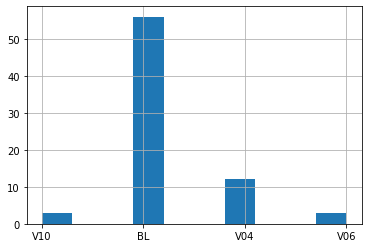

In [371]:
stable['EVENT_ID_x'].hist()

<AxesSubplot:>

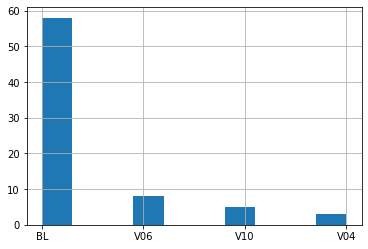

In [372]:
progr['EVENT_ID_x'].hist()

In [373]:
for visit in stable["EVENT_ID_x"].unique():
    print(f"FOR VISIT: {visit} - {len(stable[stable['EVENT_ID_x'] == visit]['PATNO'].values)} patients")
    print(','.join(map(str, stable[stable["EVENT_ID_x"] == visit]["PATNO"].values)))

FOR VISIT: V10 - 3 patients
3819,3123,3383
FOR VISIT: BL - 56 patients
3203,3711,3834,4096,3914,41410,3327,3838,85242,55151,3454,3429,3661,3430,41526,3470,50319,3420,3708,3205,3431,3960,3421,4117,3130,3419,51440,3702,3227,3700,3961,3507,3469,3322,40692,52530,3061,73115,52062,3575,50621,4110,4077,3504,3068,3051,4081,41519,53600,4076,3418,3280,40555,50901,4115,3433
FOR VISIT: V04 - 12 patients
3824,3307,3328,3832,3808,3173,3815,3175,3181,4019,50319,3592
FOR VISIT: V06 - 3 patients
3308,3111,41664


In [272]:
for visit in stable["EVENT_ID_x"].unique():
    print(f"FOR VISIT: {visit} - {len(stable[stable['EVENT_ID_x'] == visit]['PATNO'].values)} patients")
    print(','.join(map(str, stable[stable["EVENT_ID_x"] == visit]["PATNO"].values)))

FOR VISIT: V10 - 3 patients
3819,3123,3383
FOR VISIT: BL - 54 patients
3203,3711,3834,4096,3914,41410,3327,3838,85242,55151,3454,3429,3661,3430,41526,3470,50319,3420,3708,3205,3431,3960,3421,4117,3130,3419,51440,3702,3227,3700,3961,3507,3469,3322,40692,52530,3061,3575,50621,4110,4077,3504,3068,3051,4081,41519,53600,4076,3418,3280,40555,50901,4115,3433
FOR VISIT: V04 - 12 patients
3824,3307,3328,3832,3808,3173,3815,3175,3181,4019,50319,3592
FOR VISIT: V06 - 3 patients
3308,3111,41664


In [273]:
for visit in progr["EVENT_ID_x"].unique():
    print(f"FOR VISIT: {visit} - {len(progr[progr['EVENT_ID_x'] == visit]['PATNO'].values)} patients")
    print(','.join(map(str, progr[progr["EVENT_ID_x"] == visit]["PATNO"].values)) )

FOR VISIT: BL - 57 patients
3086,139859,3233,3079,4036,3655,53308,3183,3705,101735,3825,3465,5015,3407,3207,3001,137426,141135,3629,59649,3174,3505,3186,3024,3272,101146,110919,3829,3835,4093,140452,3869,3532,5013,124793,4056,115448,3963,4051,133486,3633,51675,101175,101025,3378,3366,101124,116742,100738,135579,4086,4022,137504,3764,133507,3558,120622
FOR VISIT: V06 - 7 patients
3309,3836,58327,3861,75505,52678,3375
FOR VISIT: V10 - 4 patients
59733,72222,70188,3174
FOR VISIT: V04 - 4 patients
4082,4005,4034,100267


In [283]:
mri_df[mri_df["PATNO"]==3702]

,PATNO,EVENT_ID,MRICMPLT
829,3702,BL,1.0
830,3702,V04,1.0


In [282]:
mri_df

,PATNO,EVENT_ID,MRICMPLT
0,3000,BL,1.0
1,3000,V12,0.0
2,3001,BL,1.0
3,3002,BL,1.0
4,3003,BL,1.0
...,...,...,...
2876,146935,BL,0.0
2877,147077,BL,1.0
2878,148093,BL,1.0
2879,150818,BL,1.0


Visit 01 (Month 3)
Visit 02 (Month 6)
Visit 03 (Month 9)
Visit 04 (Month 12)
Visit 05 (Month 18)
Visit 06 (Month 24)
Visit 07 (Month 30)
Visit 08 (Month 36)
Visit 09 (Month 42)
Visit 10 (Month 48)
Visit 11 (Month 54)
Visit 12 (Month 60)
Visit 13 (Month 72)
Visit 14 (Month 84)
Visit 15 (Month 96)
Visit 16 (Month 108)
Visit 17 (Month 120)
Visit 18 (Month 132)
Visit 19 (Month 144)
Visit 20 (Month 156)

visits = {'BL': 'V08', 
          'V04': 'Month 12',
          'V06': 'Month 24',
          'V08': 'Month 36',
          'V10': 'Month 48'}